# MCAO tip tilt maps

### Getting CPSDs

In [2]:
from apposto.types.aperture import CircularOpticalAperture
from apposto.types.guide_source import GuideSource
from apposto.atmo.cn2_profile import EsoEltProfiles
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance
import numpy as np
import itertools

##INITIALIZING THE GENERAL CONFIGURATION

#NGSs' configuration
theta_ngs1 = 30
az_ngs1 = 0
theta_ngs2 = -30
az_ngs2 = 0
ngs1 = GuideSource((theta_ngs1, az_ngs1), np.inf)
ngs2 = GuideSource((theta_ngs2, az_ngs2), np.inf)
ngs_list = [ngs1, ngs2]

#Optical aperture
ap_position = [0, 0, 0]
ap_radius = 5
aperture = CircularOpticalAperture(ap_radius, ap_position)

#Atmospheric profile
cn2_profile = EsoEltProfiles.Median()

#Spatial and temporal frequencies
spatial_freqs = np.logspace(-3, 3, 100)
temporal_freqs = np.logspace(-3, 3, 100)

#Targets
offsets = np.arange(11) * 10 - 50
pos_targets = np.array(list(itertools.product(offsets, offsets)))

In [3]:
#Function to get CPSDs matrices (CPSD_onon and CPSD_onoff) for one target

def getCPSDsForOneTarget(target):
    vk = VonKarmanSpatioTemporalCovariance(source1=target, source2=target, aperture1=aperture, aperture2=aperture,
                                           cn2_profile=cn2_profile, spat_freqs=spatial_freqs)
    cpsd_target_22 = vk.getGeneralZernikeCPSD(2, 2, temporal_freqs)
    cpsd_target_23 = vk.getGeneralZernikeCPSD(2, 3, temporal_freqs)
    cpsd_target_33 = vk.getGeneralZernikeCPSD(3, 3, temporal_freqs)
    cpsd_matrix_target = np.array([[cpsd_target_22, cpsd_target_23], [cpsd_target_23, cpsd_target_33]])
    
    cpsd_off_list = []
    for ngs in ngs_list:
        vk.setSource2(ngs)
        cpsd_off_22 = vk.getGeneralZernikeCPSD(2, 2, temporal_freqs)
        cpsd_off_23 = vk.getGeneralZernikeCPSD(2, 3, temporal_freqs)
        cpsd_off_33 = vk.getGeneralZernikeCPSD(3, 3, temporal_freqs)
        cpsd_off = np.array([[cpsd_off_22, cpsd_off_23], [cpsd_off_23, cpsd_off_33]])
        cpsd_off_list.append(cpsd_off)
        
    cpsd_matrix_ngs = np.vstack(cpsd_off_list)
    
    return cpsd_matrix_target, cpsd_matrix_ngs

In [4]:
#Getting the CPSDs

cpsd_mats_target = []
cpsd_mats_ngs = []
for pos in pos_targets:
    target = GuideSource(pos, np.inf)
    cpsd_targ, cpsd_ngs = getCPSDsForOneTarget(target)
    cpsd_mats_target.append(cpsd_targ)
    cpsd_mats_ngs.append(cpsd_ngs)

In [6]:
print(len(cpsd_mats_ngs))
print(len(cpsd_mats_target))
print(cpsd_mats_ngs[0].shape)
print(cpsd_mats_target[0].shape)

121
121
(4, 2, 100)
(2, 2, 100)


In [7]:
# Getting CPSD of noise
cpsd_noise = np.zeros((2, 2, 1000))

### Getting projection matrices

In [67]:
from apposto.utils.footprint_geometry import FootprintGeometry
from apposto.utils import zernike_projection_on_subaperture

z_layer1 = 0
z_layer2 = 10e3
zenith_angle = 0
fov = 100
modes_to_correct = 2 # Tip and tilt
modes_layer1 = 2 # Tip and tilt
modes_layer2 = 3 # Focus and astigmatism
    
fg = FootprintGeometry()
fg.setTelescopeRadiusInMeter(ap_radius)
fg.set_zenith_angle(zenith_angle)
fg.setInstrumentFoV(fov)
fg.addLgs(0,0,0,0)
fg.addNgs(theta_ngs1, az_ngs1)
fg.addNgs(theta_ngs2, az_ngs2)
#fg.addTarget(th_target, az_target)

In [68]:
def getProjectionMatricesForOneLayer(z_layer, n_modes_to_correct, m_modes_for_layer):
    fg.setLayerAltitude(z_layer)
    fg.compute()
    
    R = fg._metapupilL[0][2]
    h_target = np.sqrt(fg._targetsL[0][0]**2 + fg._targetsL[0][1])
    az_target = np.arctan2(fg._targetsL[0][1], fg._targetsL[0][0])
    zp_target = zernike_projection_on_subaperture.ZernikeProjectionOnSubaperture(pupilRadiusInMeter=R,
                                               subapsRadiusInMeter=ap_radius,
                                               subapOffAxisRadiusInMeter=h_target,
                                               subapOffAxisAzimuthInDegrees=az_target)
    p_on = zp_target.getProjectionMatrix()[:n_modes_to_correct,:m_modes_for_layer]
    
    h_ngs1 = np.sqrt(fg._ngsL[0][0]**2 + fg._ngsL[0][1])
    az_ngs1 = np.arctan2(fg._ngsL[0][1], fg._ngsL[0][0])
    zp_ngs1 = ZernikeProjectionOnSubaperture(pupilRadiusInMeter=R,
                                             subapsRadiusInMeter=ap_radius,
                                             subapOffAxisRadiusInMeter=h_ngs1,
                                             subapOffAxisAzimuthInDegrees=az_ngs1)
    p_ngs1 = zp_ngs1.getProjectionMatrix()[:n_modes_to_correct,:m_modes_for_layer]

    h_ngs2 = np.sqrt(fg._ngsL[1][0]**2 + fg._ngsL[1][1])
    az_ngs2 = np.arctan2(fg._ngsL[1][1], fg._ngsL[1][0])
    zp_ngs2 = ZernikeProjectionOnSubaperture(pupilRadiusInMeter=R,
                                             subapsRadiusInMeter=ap_radius,
                                             subapOffAxisRadiusInMeter=h_ngs2,
                                             subapOffAxisAzimuthInDegrees=az_ngs2)
    p_ngs2 = zp_ngs2.getProjectionMatrix()[:n_modes_to_correct,:m_modes_for_layer]
    
    p_off = np.vstack((p_ngs1, p_ngs2))
    
    return p_on, p_off

In [94]:
#Getting p_on_list containing N (= number of targets) projection matrices along the targets' direction
# and p_off_list containing N projection matrices along the NGSs' direction.
p_on_list = []
p_off_list = []

for pos in pos_targets:
    fg.addTarget(pos[0], pos[1])
    p_on_layer1, p_off_layer1 = getProjectionMatricesForOneLayer(z_layer1, modes_to_correct, modes_layer1)
    p_on_layer2, p_off_layer2 = getProjectionMatricesForOneLayer(z_layer2, modes_to_correct, modes_layer2)
    p_on = np.hstack((p_on_layer1, p_on_layer2))
    p_off = np.hstack((p_off_layer1, p_off_layer2))
    p_on_list.append(p_on)
    p_off_list.append(p_off)

In [90]:
print(len(p_on_list))
print(len(p_off_list))
print(p_on_list[0].shape)
print(p_off_list[0].shape)

121
121
(5, 2)
(5, 4)


In [91]:
#Getting the list of reconstructors
w_list = []
for p_off in p_off_list:
    w = np.linalg.pinv(p_off)
    w_list.append(w)

print(len(w_list))
print(w_list[0].shape)

121
(4, 5)


### Getting integrator

In [92]:
from apposto.utils.integrator import SimpleIntegrator

d = 3.
g = 0.3
f = temporal_freqs
ig = SimpleIntegrator()
ig.setDelay(d)
ig.setGain(g)
ig.setTemporalFrequencies(f)

### Computing MCAO residual

In [93]:
from apposto.utils.residual_calculator import ResidualCalculator

res_list = []
for i in range(len(cpsd_mats_ngs)):
    rc = ResidualCalculator(cpsd_mats_target[i], cpsd_mats_ngs[i], cpsd_noise, ig)
    res = rc.getMCAOResidual(p_on_list[i], p_off_list[i], w_list[i], temporal_freqs).real
    res_list.append(res)

print(len(res_list))
print(res_list[0].shape)
print(res_list[0])

ValueError: shapes (5,2) and (4,5) not aligned: 2 (dim 1) != 4 (dim 0)

## Tip tilt maps

In [84]:
#Definition of functions needed to plot the ellipses.
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse

def getCartesianPositions(rho, theta):
    x = rho * np.cos(np.deg2rad(theta))
    y = rho * np.sin(np.deg2rad(theta))
    return x, y


def computeEllipseParameters(covariance_matrix, nstd=1):
    eig_values, eig_vectors = np.linalg.eigh(covariance_matrix)
    order = eig_values.argsort()[::-1]
    val_sort, vect_sort = eig_values[order], eig_vectors[:, order]
    theta = np.rad2deg(np.arctan2(vect_sort[:, 0][1], vect_sort[:, 0][0]))
    width, height = 2 * nstd * np.sqrt(val_sort)
    return width, height, theta

def ellipsePlot(distances_xy, width, height, angle,
                x_max, x_min, y_max, y_min, scale=4):    
    mpl.rcParams['figure.dpi'] = 200
    ellipse = [Ellipse((distances_xy[i, 0], distances_xy[i, 1]),
                       width[i]/scale, height[i]/scale, angle=angle[i]) for i in range(len(width))]
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    for e in ellipse:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

Text(0, 0.5, 'arcsec')

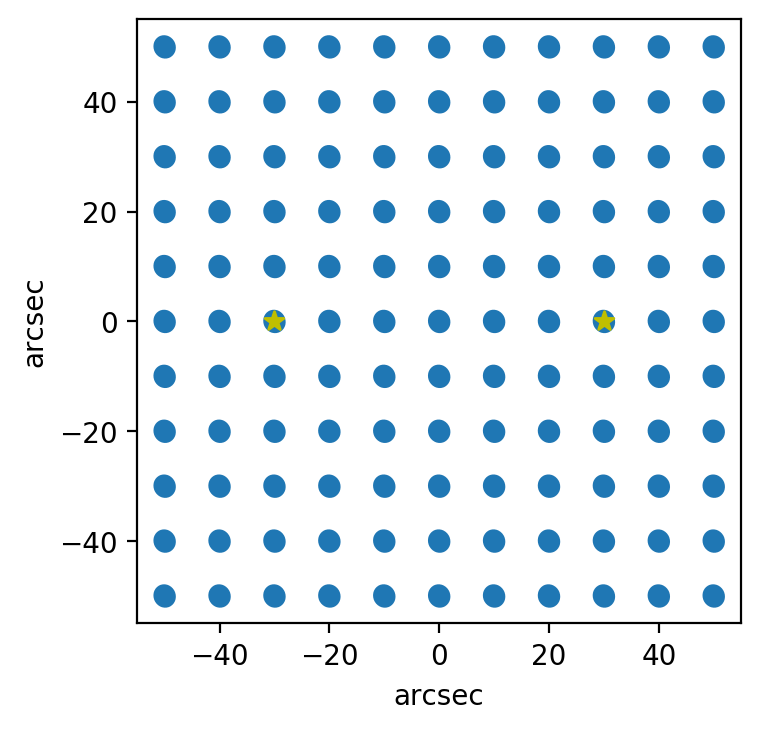

In [85]:
#Computation of covariance ellipses' parameters.

#positionsInXY = np.stack(getCartesianPositions(theta_targets, az_targets), axis=-1)
widths = []
heights = []
ths = []
for res in res_list:
    w, h, t = computeEllipseParameters(covariance_matrix=res, nstd=1)
    widths.append(w)
    heights.append(h)
    ths.append(t)

#Plot of the tip tilt map (field in XY coordinates).
import matplotlib.pyplot as plt
ellipsePlot(distances_xy=pos_targets, width=widths, height=heights, angle=ths,
            x_max=55, x_min=-55, y_max=55, y_min=-55)

x_ngs1, y_ngs1 = getCartesianPositions(theta_ngs1, az_ngs1)
x_ngs2, y_ngs2 = getCartesianPositions(theta_ngs2, az_ngs2)
plt.scatter(x_ngs1, y_ngs1, marker='*', s=50, color='y', zorder=2)
plt.scatter(x_ngs2, y_ngs2, marker='*', s=50, color='y', zorder=2)
plt.xlabel('arcsec')
plt.ylabel('arcsec')